## Installation & Setup

In [1]:
!pip install jellyfish py_stringmatching sentence-transformers openai tqdm scikit-learn python-dotenv


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [21]:
# 📚 IMPORTS
import pandas as pd
import numpy as np
import time
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# String matching
import jellyfish
import py_stringmatching as sm

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Embeddings
from sentence_transformers import SentenceTransformer

# OpenAI
from openai import OpenAI
from dotenv import load_dotenv

# Display
from IPython.display import display

print("Libraries Imported Successfully!")

Libraries Imported Successfully!


## Configuration

- **TEST_MODE = True**: Uses only 100 records 
- **TEST_MODE = False**: Uses full dataset

In [22]:
# TEST MODE: Set to True for quick test (100 records)
TEST_MODE = False  # 

# Dataset selection
DATASET_NAME = 'abt-buy'  # Options: 'abt-buy', 'amazon-google', 'dblp-acm', 'dblp-scholar'


CONFIG = {
    'dataset_name': DATASET_NAME,
    
    # Abt-Buy paths (using ../ to go up from notebooks/ folder)
    'dataset_a': '../data/abt-buy/Abt.csv',
    'dataset_b': '../data/abt-buy/Buy.csv',
    'dataset_a_ciphered': '../data/abt-buy/Abt_ciphered.csv',
    'dataset_b_ciphered': '../data/abt-buy/Buy_ciphered.csv',
    'dataset_a_scrambled': '../data/abt-buy/Abt_scrambled.csv',
    'dataset_b_scrambled': '../data/abt-buy/Buy_scrambled.csv',
    'ground_truth': '../data/abt-buy/abt_buy_perfectMapping.csv',
    
    # Column names for Abt-Buy
    'id_col_a': 'id',
    'id_col_b': 'id',
    'text_cols': ['name', 'description'],
    'gt_col_a': 'idAbt',
    'gt_col_b': 'idBuy',
}

# Amazon-Google:
# CONFIG['text_cols'] = ['title', 'description', 'manufacturer']
# CONFIG['gt_col_a'] = 'idAmazon'
# CONFIG['gt_col_b'] = 'idGoogleProducts'

# DBLP-ACM or DBLP-Scholar:
# CONFIG['text_cols'] = ['title', 'authors', 'venue']
# CONFIG['gt_col_a'] = 'idDBLP'
# CONFIG['gt_col_b'] = 'idACM'  # or 'idScholar'


# OpenAI API Key
load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

if OPENAI_API_KEY:
    client = OpenAI(api_key=OPENAI_API_KEY)
    print("OpenAI API key loaded")
else:
    print("No OpenAI API key - OpenAI methods will be skipped")

# Display Settings
print("\n" + "="*60)
if TEST_MODE:
    print("TEST MODE ENABLED")
    print("- Using only 100 records per dataset")
else:
    print("FULL MODE ENABLED")
    print("- Using complete datasets")
print("="*60)
print(f"Dataset: {CONFIG['dataset_name']}")
print("="*60)

OpenAI API key loaded

FULL MODE ENABLED
- Using complete datasets
Dataset: abt-buy


## Load Data

In [27]:
def load_csv_with_encoding(filepath):
    """
    Load CSV with automatic encoding detection.
    Tries UTF-8, Latin-1, Windows-1252, and ISO-8859-1.
    """
    encodings = ['utf-8', 'latin-1', 'windows-1252', 'iso-8859-1']
    
    for encoding in encodings:
        try:
            df = pd.read_csv(filepath, encoding=encoding)
            print(f"Loaded with {encoding} encoding")
            return df
        except (UnicodeDecodeError, UnicodeError):
            continue
    
    # If all fail, raise error
    raise ValueError(f"Could not read {filepath} with any encoding: {encodings}")


try:
    df_a = load_csv_with_encoding(CONFIG['dataset_a'])
    print(f"Dataset A: {len(df_a):,} records\n")
    
    df_b = load_csv_with_encoding(CONFIG['dataset_b'])
    print(f"Dataset B: {len(df_b):,} records\n")
    
    df_a_ciphered = load_csv_with_encoding(CONFIG['dataset_a_ciphered'])
    print(f"Ciphered A: {len(df_a_ciphered):,} records\n")
    
    df_b_ciphered = load_csv_with_encoding(CONFIG['dataset_b_ciphered'])
    print(f"Ciphered B: {len(df_b_ciphered):,} records\n")
    
    df_a_scrambled = load_csv_with_encoding(CONFIG['dataset_a_scrambled'])
    print(f"Scrambled A: {len(df_a_scrambled):,} records\n")
    
    df_b_scrambled = load_csv_with_encoding(CONFIG['dataset_b_scrambled'])
    print(f"Scrambled B: {len(df_b_scrambled):,} records\n")
    
    ground_truth = load_csv_with_encoding(CONFIG['ground_truth'])
    print(f"Ground Truth: {len(ground_truth):,} known matches")
    
except FileNotFoundError as e:
    print(f"\nERROR: Could not find file!")  
    raise

# Create aliases for the datasets dictionary
df_abt_original = df_a
df_buy_original = df_b
df_abt_ciphered = df_a_ciphered
df_buy_ciphered = df_b_ciphered
df_abt_scrambled = df_a_scrambled
df_buy_scrambled = df_b_scrambled


# ============================================
# APPLY TEST MODE
# ============================================

if TEST_MODE:
    print("\n" + "="*60)
    print("TEST MODE: Reducing to 100 records per dataset")
    print("="*60)
    
    df_a = df_a.head(100)
    df_b = df_b.head(100)
    df_a_ciphered = df_a_ciphered.head(100)
    df_b_ciphered = df_b_ciphered.head(100)
    df_a_scrambled = df_a_scrambled.head(100)
    df_b_scrambled = df_b_scrambled.head(100)
    
    print(f" Reduced to {len(df_a)} × {len(df_b)} = {len(df_a) * len(df_b):,} comparisons")
    print(f"   (Original would be {1081 * 1092:,} comparisons)")
    print("="*60)

# Preview
print("\nData Preview:")
display(df_a.head(5))

Loaded with latin-1 encoding
Dataset A: 1,081 records

Loaded with utf-8 encoding
Dataset B: 1,092 records

Loaded with latin-1 encoding
Ciphered A: 1,081 records

Loaded with utf-8 encoding
Ciphered B: 1,092 records

Loaded with latin-1 encoding
Scrambled A: 1,081 records

Loaded with utf-8 encoding
Scrambled B: 1,092 records

Loaded with utf-8 encoding
Ground Truth: 1,097 known matches

Data Preview:


,id,name,description,price
0,552,Sony Turntable - PSLX350H,Sony Turntable - PSLX350H/ Belt Drive System/ ...,NaN
1,580,Bose Acoustimass 5 Series III Speaker System -...,Bose Acoustimass 5 Series III Speaker System -...,$399.00
2,4696,Sony Switcher - SBV40S,Sony Switcher - SBV40S/ Eliminates Disconnecti...,$49.00
3,5644,Sony 5 Disc CD Player - CDPCE375,Sony 5 Disc CD Player- CDPCE375/ 5 Disc Change...,NaN
4,6284,Bose 27028 161 Bookshelf Pair Speakers In Whit...,Bose 161 Bookshelf Speakers In White - 161WH/ ...,$158.00


## Text Preprocessing

In [28]:
""" 
1. Handle missing values
2. Convert to lowercase
3. Combine multiple columns into one 'text' column
"""

def preprocess_text(df, text_columns):
    """
    Preprocess text for matching.
    """
    for col in text_columns:
        df[col] = df[col].fillna('')
    
    df['text'] = df[text_columns].apply(
        lambda row: ' '.join(row.values.astype(str)).lower().strip(),
        axis=1
    )
    
    return df

df_a = preprocess_text(df_a, CONFIG['text_cols'])
df_b = preprocess_text(df_b, CONFIG['text_cols'])
df_a_ciphered = preprocess_text(df_a_ciphered, CONFIG['text_cols'])
df_b_ciphered = preprocess_text(df_b_ciphered, CONFIG['text_cols'])
df_a_scrambled = preprocess_text(df_a_scrambled, CONFIG['text_cols'])
df_b_scrambled = preprocess_text(df_b_scrambled, CONFIG['text_cols'])

print("All datasets preprocessed")

All datasets preprocessed


## Build Ground Truth Set

In [29]:
true_matches = set(
    zip(
        ground_truth[CONFIG['gt_col_a']].astype(str),
        ground_truth[CONFIG['gt_col_b']].astype(str)
    )
)

print(f"Ground truth: {len(true_matches):,} true matches")

Ground truth: 1,097 true matches


## Implementing Matching Methods

In [30]:
# ==================================================
# METHOD 1: Jaro-Winkler
# ==================================================

def jaro_winkler_similarity(str1, str2):
    """Character-level similarity with prefix boost."""
    return jellyfish.jaro_winkler_similarity(str1, str2)

print("Jaro-Winkler ready")

# ==================================================
# METHOD 2: Levenshtein
# ==================================================

def levenshtein_similarity(str1, str2):
    """Edit distance normalized to 0-1."""
    distance = jellyfish.levenshtein_distance(str1, str2)
    max_len = max(len(str1), len(str2))
    if max_len == 0:
        return 1.0
    return 1.0 - (distance / max_len)

print("Levenshtein ready")

# ==================================================
# METHOD 3: Monge-Elkan
# ==================================================

def monge_elkan_similarity(str1, str2):
    """Token-level matching with Jaro-Winkler base."""
    tokens_a = str1.split()
    tokens_b = str2.split()
    
    if len(tokens_a) == 0 or len(tokens_b) == 0:
        return 0.0
    
    sum_best = 0.0
    for token_a in tokens_a:
        best = max([jaro_winkler_similarity(token_a, token_b) for token_b in tokens_b])
        sum_best += best
    
    return sum_best / len(tokens_a)

print("Monge-Elkan ready")

# ==================================================
# METHOD 4: Soft-TFIDF
# ==================================================

def soft_tfidf_similarity(str1, str2, theta=0.9):
    """
    Soft-TFIDF with Jaro-Winkler and θ = 0.9.
    Simplified version - uses token matching.
    """
    tokens_a = str1.split()
    tokens_b = str2.split()
    
    if len(tokens_a) == 0 or len(tokens_b) == 0:
        return 0.0
    
    score = 0.0
    for token_a in tokens_a:
        best_match = max([jaro_winkler_similarity(token_a, token_b) for token_b in tokens_b])
        if best_match >= theta:
            score += best_match
    
    return score / len(tokens_a) if len(tokens_a) > 0 else 0.0

print("Soft-TFIDF ready")


# ==================================================
# METHOD 5: TF-IDF
# ==================================================

def tfidf_matching(df_a, df_b, threshold, id_col_a, id_col_b):
    """
    TF-IDF cosine similarity with Top-1 matching.
    """
    vectorizer = TfidfVectorizer()
    all_texts = pd.concat([df_a['text'], df_b['text']])
    vectorizer.fit(all_texts)
    
    vectors_a = vectorizer.transform(df_a['text'])
    vectors_b = vectorizer.transform(df_b['text'])
    similarity_matrix = cosine_similarity(vectors_a, vectors_b)
    
    predicted_matches = set()
    for idx_a in range(len(df_a)):
        best_idx_b = np.argmax(similarity_matrix[idx_a])
        best_sim = similarity_matrix[idx_a, best_idx_b]
        
        if best_sim >= threshold:
            id_a = str(df_a.iloc[idx_a][id_col_a])
            id_b = str(df_b.iloc[best_idx_b][id_col_b])
            predicted_matches.add((id_a, id_b))
    
    return predicted_matches

print("TF-IDF ready")

# ==================================================
# METHOD 6: SentenceTransformer
# ==================================================

sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

def sentence_transformer_matching(df_a, df_b, threshold, id_col_a, id_col_b):
    """
    SentenceTransformer embedding matching.
    """
    embeddings_a = sentence_model.encode(df_a['text'].tolist(), show_progress_bar=False)
    embeddings_b = sentence_model.encode(df_b['text'].tolist(), show_progress_bar=False)
    similarity_matrix = cosine_similarity(embeddings_a, embeddings_b)
    
    predicted_matches = set()
    for idx_a in range(len(df_a)):
        best_idx_b = np.argmax(similarity_matrix[idx_a])
        best_sim = similarity_matrix[idx_a, best_idx_b]
        
        if best_sim >= threshold:
            id_a = str(df_a.iloc[idx_a][id_col_a])
            id_b = str(df_b.iloc[best_idx_b][id_col_b])
            predicted_matches.add((id_a, id_b))
    
    return predicted_matches

print("Sentence Transformer matching ready")

# ==================================================
# METHOD 7: OpenAI Embedding Method
# ==================================================

if OPENAI_API_KEY:
    
    def get_openai_embeddings(texts, model="text-embedding-3-small"):
        """Get OpenAI embeddings in batches."""
        embeddings = []
        batch_size = 100
        
        for i in tqdm(range(0, len(texts), batch_size), desc="OpenAI embeddings"):
            batch = texts[i:i+batch_size]
            response = client.embeddings.create(model=model, input=batch)
            batch_embeddings = [item.embedding for item in response.data]
            embeddings.extend(batch_embeddings)
            time.sleep(0.1)
        
        return np.array(embeddings)
    
    def openai_embedding_matching(df_a, df_b, threshold, id_col_a, id_col_b):
        """OpenAI embedding matching."""
        embeddings_a = get_openai_embeddings(df_a['text'].tolist())
        embeddings_b = get_openai_embeddings(df_b['text'].tolist())
        similarity_matrix = cosine_similarity(embeddings_a, embeddings_b)
        
        predicted_matches = set()
        for idx_a in range(len(df_a)):
            best_idx_b = np.argmax(similarity_matrix[idx_a])
            best_sim = similarity_matrix[idx_a, best_idx_b]
            
            if best_sim >= threshold:
                id_a = str(df_a.iloc[idx_a][id_col_a])
                id_b = str(df_b.iloc[best_idx_b][id_col_b])
                predicted_matches.add((id_a, id_b))
        
        return predicted_matches
    
    print("OpenaAI Embedding matching ready")
    
# ==================================================
# METHOD 8: LLM Matching Method
# ==================================================
    
    def llm_match_with_blocking(record_a, df_b, id_col_b, top_k=20):  
        """LLM matching with Jaro-Winkler blocking - IMPROVED VERSION."""
        text_a = record_a['text']
        
        # Find top-K candidates using Jaro-Winkler
        similarities = []
        for idx_b, row_b in df_b.iterrows():
            sim = jaro_winkler_similarity(text_a, row_b['text'])
            similarities.append((idx_b, sim, row_b[id_col_b], row_b['text']))
        
        similarities.sort(key=lambda x: x[1], reverse=True)
        top_candidates = similarities[:top_k]
        
        if len(top_candidates) == 0 or top_candidates[0][1] < 0.1:  
            return None, 0.0, 0.0, "No candidates" 
        
        # Build LLM prompt with full text
        candidates_list = []
        for i, cand in enumerate(top_candidates):
            text = cand[3]
            if len(text) > 500:  
                text = text[:500] + "..."
            candidates_list.append(f"[{i+1}] {text}")
        
        candidates_text = "\n\n".join(candidates_list)
        
        # Truncate query text if needed
        query_text = text_a
        if len(query_text) > 500: 
            query_text = query_text[:500] + "..."
        
        prompt = f"""You are an expert at entity matching for product databases. 
        Your task is to determine if any candidate record matches the query record, 
        considering they come from different sources with varying descriptions.

    QUERY RECORD:
    {query_text}

    CANDIDATE RECORDS:
    {candidates_text}

    MATCHING GUIDELINES:
    - Products are the SAME if they refer to the same model/item, even with different descriptions
    - Consider: brand names, model numbers, key specifications
    - Account for: abbreviations (e.g., "PS5" = "PlayStation 5"), different word orders, extra/missing details
    - Be strict about: core product identity (don't match PS5 with PS4, iPad Pro 11" with iPad Pro 12.9")

    RESPONSE FORMAT:
    If a match exists, respond with:
    Match: [number]
    Confidence: [0.0 to 1.0]
    Reasoning: [brief explanation]

    If no match exists, respond with:
    Match: 0
    Confidence: [0.0 to 1.0]
    Reasoning: [why no candidates match]

    Your response:"""
        
        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0
            )
            
            answer = response.choices[0].message.content.strip()
            tokens = response.usage.total_tokens
            cost = (tokens / 1_000_000) * 0.15
            match_num = 0
            confidence = 0.0
            reasoning = answer
            
            lines = answer.split('\n')
            for line in lines:
                line = line.strip()
                if line.startswith('Match:'):
                    try:
                        match_num = int(''.join(c for c in line.split('Match:')[1] if c.isdigit()))
                    except:
                        pass
                elif line.startswith('Confidence:'):
                    try:
                        conf_str = line.split('Confidence:')[1].strip()
                        confidence = float(''.join(c for c in conf_str if c.isdigit() or c == '.'))
                        if confidence > 1.0:
                            confidence = confidence / 100.0
                    except:
                        pass
                elif line.startswith('Reasoning:'):
                    reasoning = line.split('Reasoning:')[1].strip()
            
            if match_num > 0 and match_num <= len(top_candidates):
                matched_id = top_candidates[match_num - 1][2]
                return matched_id, confidence, cost, reasoning  
            
            return None, confidence, cost, reasoning  
            
        except Exception as e:
            return None, 0.0, 0.0, f"Error: {str(e)}"  


    def llm_matching_with_blocking(df_a, df_b, id_col_a, id_col_b, top_k=20): 
        """Full LLM matching - IMPROVED VERSION."""
        predicted_matches = set()
        total_cost = 0.0
        all_details = [] 
        
        for idx_a, row_a in tqdm(df_a.iterrows(), total=len(df_a), desc="LLM matching (improved)"):
            matched_id, confidence, cost, reasoning = llm_match_with_blocking(
                row_a, df_b, id_col_b, top_k
            )
            total_cost += cost
            
            all_details.append({
                'id_a': str(row_a[id_col_a]),
                'matched_id_b': str(matched_id) if matched_id else None,
                'confidence': confidence,
                'reasoning': reasoning
            })

            if matched_id and confidence >= 0.0:
                predicted_matches.add((str(row_a[id_col_a]), str(matched_id)))
        
        return predicted_matches, total_cost, pd.DataFrame(all_details) 
    
    def optimize_llm_threshold(df_a, df_b, true_matches, id_col_a, id_col_b, details_df):
        """
        Optimize confidence threshold using cached LLM results.
        No additional API calls needed!
        """
        print("Optimizing confidence threshold...")
        
        thresholds = np.arange(0.0, 1.01, 0.05)
        best_threshold = 0.5
        best_f1 = 0.0
        
        total_pairs = len(df_a) * len(df_b)
        
        for threshold in thresholds:
            predicted = set()
            for _, row in details_df.iterrows():
                if row['matched_id_b'] is not None and row['confidence'] >= threshold:
                    predicted.add((row['id_a'], row['matched_id_b']))
            
            tp = len(predicted & true_matches)
            fp = len(predicted - true_matches)
            fn = len(true_matches - predicted)
            
            precision = tp / len(predicted) if len(predicted) > 0 else 0.0
            recall = tp / len(true_matches) if len(true_matches) > 0 else 0.0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        print(f"Best threshold: {best_threshold:.2f}, F1: {best_f1:.3f}")
        
        return best_threshold, None
    
    print("LLM matching ready")
    print("\nAll 8 methods loaded")

Jaro-Winkler ready
Levenshtein ready
Monge-Elkan ready
Soft-TFIDF ready
TF-IDF ready
Sentence Transformer matching ready
OpenaAI Embedding matching ready
LLM matching ready

All 8 methods loaded


## Top-1 Matching & Evaluation

In [31]:
def top1_matching(df_a, df_b, similarity_function, threshold, id_col_a, id_col_b):
    """
    Top-1 matching strategy.
    """
    predicted_matches = set()
    
    for idx_a, row_a in tqdm(df_a.iterrows(), total=len(df_a), desc="Matching"):
        best_sim = 0.0
        best_match_id = None
        
        for idx_b, row_b in df_b.iterrows():
            sim = similarity_function(row_a['text'], row_b['text'])
            if sim > best_sim:
                best_sim = sim
                best_match_id = row_b[id_col_b]
        
        if best_sim >= threshold:
            predicted_matches.add((str(row_a[id_col_a]), str(best_match_id)))
    
    return predicted_matches

def calculate_metrics(predicted_matches, true_matches, total_possible_pairs):
    """
    Calculate evaluation metrics.
    """
    tp = len(predicted_matches & true_matches)
    fp = len(predicted_matches - true_matches)
    fn = len(true_matches - predicted_matches)
    tn = total_possible_pairs - tp - fp - fn
    
    precision = tp / len(predicted_matches) if len(predicted_matches) > 0 else 0.0
    recall = tp / len(true_matches) if len(true_matches) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    accuracy = (tp + tn) / total_possible_pairs if total_possible_pairs > 0 else 0.0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'true_positives': tp,
        'false_positives': fp,
        'false_negatives': fn
    }

def find_best_threshold(df_a, df_b, similarity_function, true_matches,
                        id_col_a, id_col_b, method_name):
    """
    Find optimal threshold.
    """
    print(f"\n🔍 Optimizing threshold for {method_name}...")
    
    thresholds = np.arange(0.50, 0.96, 0.05)
    best_threshold = 0.0
    best_f1 = 0.0
    total_pairs = len(df_a) * len(df_b)
    
    for threshold in thresholds:
        predicted = top1_matching(df_a, df_b, similarity_function,
                                  threshold, id_col_a, id_col_b)
        metrics = calculate_metrics(predicted, true_matches, total_pairs)
        
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_threshold = threshold
        
        print(f"  Threshold {threshold:.2f}: F1={metrics['f1']:.3f}")
    
    print(f"\nBest: {best_threshold:.2f} (F1={best_f1:.3f})")
    return best_threshold

print("Matching and evaluation functions ready!")

Matching and evaluation functions ready!


## Run All Experiments

In [32]:
# Initialize
all_results = []
experiment_num = 1

# Create datasets dictionary
datasets = {
    'Original': (df_abt_original, df_buy_original),
    'Ciphered': (df_abt_ciphered, df_buy_ciphered),
    'Scrambled': (df_abt_scrambled, df_buy_scrambled)
}

# String methods dictionary
string_methods = {
    'Jaro-Winkler': jaro_winkler_similarity,
    'Levenshtein': levenshtein_similarity,
    'Monge-Elkan': monge_elkan_similarity,
    'Soft-TFIDF': soft_tfidf_similarity
}

# ============================================
# STRING METHODS (1-4)
# ============================================
for method_name, similarity_func in string_methods.items():
    for dataset_name, (data_a, data_b) in datasets.items():
        print(f"\n[{experiment_num}] {method_name} on {dataset_name}")
        
        best_threshold = find_best_threshold(
            data_a, data_b, similarity_func, true_matches,
            CONFIG['id_col_a'], CONFIG['id_col_b'], method_name
        )
        
        predicted = top1_matching(
            data_a, data_b, similarity_func,
            best_threshold, CONFIG['id_col_a'], CONFIG['id_col_b']
        )
        
        metrics = calculate_metrics(predicted, true_matches, len(data_a) * len(data_b))
        
        all_results.append({
            'Method': method_name,
            'Dataset': dataset_name,
            'Threshold': best_threshold,
            'F1': metrics['f1'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'Accuracy': metrics['accuracy'],
            'Time (s)': 0.0,
            'Cost ($)': 0.0
        })
        
        print(f"F1={metrics['f1']:.3f}")
        experiment_num += 1

# ============================================
# TF-IDF (5)
# ============================================
for dataset_name, (data_a, data_b) in datasets.items():
    print(f"\n[{experiment_num}] TF-IDF on {dataset_name}")
    
    best_threshold = 0.0
    best_f1 = 0.0
    
    for threshold in np.arange(0.50, 0.96, 0.05):
        predicted = tfidf_matching(data_a, data_b, threshold,
                                  CONFIG['id_col_a'], CONFIG['id_col_b'])
        metrics = calculate_metrics(predicted, true_matches, len(data_a) * len(data_b))
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_threshold = threshold
    
    all_results.append({
        'Method': 'TF-IDF',
        'Dataset': dataset_name,
        'Threshold': best_threshold,
        'F1': best_f1,
        'Precision': 0.0,
        'Recall': 0.0,
        'Accuracy': 0.0,
        'Time (s)': 0.0,
        'Cost ($)': 0.0
    })
    
    print(f"F1={best_f1:.3f}")
    experiment_num += 1

# ============================================
# SENTENCETRANSFORMER (6)
# ============================================
for dataset_name, (data_a, data_b) in datasets.items():
    print(f"\n[{experiment_num}] SentenceTransformer on {dataset_name}")
    
    best_threshold = 0.0
    best_f1 = 0.0
    
    for threshold in np.arange(0.50, 0.96, 0.05):
        predicted = sentence_transformer_matching(data_a, data_b, threshold,
                                                 CONFIG['id_col_a'], CONFIG['id_col_b'])
        metrics = calculate_metrics(predicted, true_matches, len(data_a) * len(data_b))
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_threshold = threshold
    
    all_results.append({
        'Method': 'SentenceTransformer',
        'Dataset': dataset_name,
        'Threshold': best_threshold,
        'F1': best_f1,
        'Precision': 0.0,
        'Recall': 0.0,
        'Accuracy': 0.0,
        'Time (s)': 0.0,
        'Cost ($)': 0.0
    })
    
    print(f"F1={best_f1:.3f}")
    experiment_num += 1

# ============================================
# OPENAI EMBEDDINGS (7)
# ============================================
if OPENAI_API_KEY:
    for dataset_name, (data_a, data_b) in datasets.items():
        print(f"\n[{experiment_num}] OpenAI Embeddings on {dataset_name}")
        
        best_threshold = 0.0
        best_f1 = 0.0
        
        for threshold in np.arange(0.50, 0.96, 0.05):
            predicted = openai_embedding_matching(data_a, data_b, threshold,
                                                 CONFIG['id_col_a'], CONFIG['id_col_b'])
            metrics = calculate_metrics(predicted, true_matches, len(data_a) * len(data_b))
            if metrics['f1'] > best_f1:
                best_f1 = metrics['f1']
                best_threshold = threshold
        
        est_cost = (len(data_a) + len(data_b)) * 0.00002
        
        all_results.append({
            'Method': 'OpenAI-Embedding',
            'Dataset': dataset_name,
            'Threshold': best_threshold,
            'F1': best_f1,
            'Precision': 0.0,
            'Recall': 0.0,
            'Accuracy': 0.0,
            'Time (s)': 0.0,
            'Cost ($)': est_cost
        })
        
        print(f"F1={best_f1:.3f}, Cost=${est_cost:.4f}")
        experiment_num += 1

# ============================================
# LLM (8)
# ============================================

if OPENAI_API_KEY:
    for dataset_name, (data_a, data_b) in datasets.items():
        print(f"\n[{experiment_num}] LLM (GPT-4o-mini) on {dataset_name}")
        print("="*80)
        print("  Parameters: top-k=20, blocking=0.1, max_length=500")
        
        start_time = time.time()
        
        # Get predictions with confidence scores
        predicted, llm_cost, details_df = llm_matching_with_blocking(
            data_a, data_b,
            CONFIG['id_col_a'], CONFIG['id_col_b'],
            top_k=20,
        )
        
        print(f"\nCost: ${llm_cost:.3f}")
        print(f"Initial predictions: {len(predicted)}")
        
        # Optimize threshold
        best_threshold, _ = optimize_llm_threshold(
            data_a, data_b, true_matches,
            CONFIG['id_col_a'], CONFIG['id_col_b'],
            details_df
        )
        
        # Get optimized predictions
        predicted_optimized = set()
        for _, row in details_df.iterrows():
            if row['matched_id_b'] is not None and row['confidence'] >= best_threshold:
                predicted_optimized.add((row['id_a'], row['matched_id_b']))
        
        metrics = calculate_metrics(predicted_optimized, true_matches, len(data_a) * len(data_b))
        exec_time = time.time() - start_time
        
        all_results.append({
            'Method': 'LLM-GPT4o-mini',
            'Dataset': dataset_name,
            'Threshold': best_threshold,
            'F1': metrics['f1'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'Accuracy': metrics['accuracy'],
            'Time (s)': exec_time,
            'Cost ($)': llm_cost
        })
        
        # Save details for original dataset
        if dataset_name == 'Original':
            details_df.to_csv('llm_details_original.csv', index=False)
            print(f"\n💾 Saved detailed results to 'llm_details_original.csv'")
        
        print(f"✅ F1={metrics['f1']:.3f}, Threshold={best_threshold:.2f}, Cost=${llm_cost:.3f}")
        experiment_num += 1


[1] Jaro-Winkler on Original

🔍 Optimizing threshold for Jaro-Winkler...


Matching: 100%|██████████| 1081/1081 [01:11<00:00, 15.03it/s]


  Threshold 0.50: F1=0.066


Matching: 100%|██████████| 1081/1081 [01:10<00:00, 15.37it/s]


  Threshold 0.55: F1=0.066


Matching: 100%|██████████| 1081/1081 [01:13<00:00, 14.66it/s]


  Threshold 0.60: F1=0.066


Matching: 100%|██████████| 1081/1081 [01:05<00:00, 16.58it/s]


  Threshold 0.65: F1=0.066


Matching: 100%|██████████| 1081/1081 [01:00<00:00, 17.75it/s]


  Threshold 0.70: F1=0.071


Matching: 100%|██████████| 1081/1081 [01:02<00:00, 17.31it/s]


  Threshold 0.75: F1=0.084


Matching: 100%|██████████| 1081/1081 [01:01<00:00, 17.44it/s]


  Threshold 0.80: F1=0.084


Matching: 100%|██████████| 1081/1081 [01:02<00:00, 17.43it/s]


  Threshold 0.85: F1=0.011


Matching: 100%|██████████| 1081/1081 [01:02<00:00, 17.38it/s]


  Threshold 0.90: F1=0.000


Matching: 100%|██████████| 1081/1081 [01:02<00:00, 17.36it/s]


  Threshold 0.95: F1=0.000

Best: 0.80 (F1=0.084)


Matching: 100%|██████████| 1081/1081 [01:01<00:00, 17.51it/s]


F1=0.084

[2] Jaro-Winkler on Ciphered

🔍 Optimizing threshold for Jaro-Winkler...


Matching: 100%|██████████| 1081/1081 [01:01<00:00, 17.44it/s]


  Threshold 0.50: F1=0.066


Matching: 100%|██████████| 1081/1081 [01:02<00:00, 17.42it/s]


  Threshold 0.55: F1=0.066


Matching: 100%|██████████| 1081/1081 [01:01<00:00, 17.47it/s]


  Threshold 0.60: F1=0.066


Matching: 100%|██████████| 1081/1081 [01:01<00:00, 17.51it/s]


  Threshold 0.65: F1=0.066


Matching: 100%|██████████| 1081/1081 [01:01<00:00, 17.52it/s]


  Threshold 0.70: F1=0.071


Matching: 100%|██████████| 1081/1081 [01:01<00:00, 17.46it/s]


  Threshold 0.75: F1=0.084


Matching: 100%|██████████| 1081/1081 [01:01<00:00, 17.47it/s]


  Threshold 0.80: F1=0.084


Matching: 100%|██████████| 1081/1081 [01:02<00:00, 17.39it/s]


  Threshold 0.85: F1=0.011


Matching: 100%|██████████| 1081/1081 [01:01<00:00, 17.49it/s]


  Threshold 0.90: F1=0.000


Matching: 100%|██████████| 1081/1081 [01:09<00:00, 15.48it/s]


  Threshold 0.95: F1=0.000

Best: 0.80 (F1=0.084)


Matching: 100%|██████████| 1081/1081 [01:12<00:00, 14.87it/s]


F1=0.084

[3] Jaro-Winkler on Scrambled

🔍 Optimizing threshold for Jaro-Winkler...


Matching: 100%|██████████| 1081/1081 [01:08<00:00, 15.86it/s]


  Threshold 0.50: F1=0.039


Matching: 100%|██████████| 1081/1081 [01:08<00:00, 15.88it/s]


  Threshold 0.55: F1=0.039


Matching: 100%|██████████| 1081/1081 [01:10<00:00, 15.24it/s]


  Threshold 0.60: F1=0.039


Matching: 100%|██████████| 1081/1081 [01:07<00:00, 16.02it/s]


  Threshold 0.65: F1=0.038


Matching: 100%|██████████| 1081/1081 [01:05<00:00, 16.53it/s]


  Threshold 0.70: F1=0.036


Matching: 100%|██████████| 1081/1081 [01:01<00:00, 17.49it/s]


  Threshold 0.75: F1=0.023


Matching: 100%|██████████| 1081/1081 [01:00<00:00, 17.75it/s]


  Threshold 0.80: F1=0.012


Matching: 100%|██████████| 1081/1081 [01:00<00:00, 17.81it/s]


  Threshold 0.85: F1=0.000


Matching: 100%|██████████| 1081/1081 [01:00<00:00, 17.90it/s]


  Threshold 0.90: F1=0.000


Matching: 100%|██████████| 1081/1081 [01:00<00:00, 17.77it/s]


  Threshold 0.95: F1=0.000

Best: 0.50 (F1=0.039)


Matching: 100%|██████████| 1081/1081 [01:00<00:00, 17.83it/s]


F1=0.039

[4] Levenshtein on Original

🔍 Optimizing threshold for Levenshtein...


Matching: 100%|██████████| 1081/1081 [03:38<00:00,  4.94it/s]


  Threshold 0.50: F1=0.005


Matching: 100%|██████████| 1081/1081 [03:38<00:00,  4.95it/s]


  Threshold 0.55: F1=0.002


Matching: 100%|██████████| 1081/1081 [03:47<00:00,  4.74it/s]


  Threshold 0.60: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:40<00:00,  4.91it/s]


  Threshold 0.65: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:48<00:00,  4.73it/s]


  Threshold 0.70: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:53<00:00,  4.63it/s]


  Threshold 0.75: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:45<00:00,  4.79it/s]


  Threshold 0.80: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:43<00:00,  4.84it/s]


  Threshold 0.85: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:42<00:00,  4.85it/s]


  Threshold 0.90: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:41<00:00,  4.87it/s]


  Threshold 0.95: F1=0.000

Best: 0.50 (F1=0.005)


Matching: 100%|██████████| 1081/1081 [03:48<00:00,  4.73it/s]


F1=0.005

[5] Levenshtein on Ciphered

🔍 Optimizing threshold for Levenshtein...


Matching: 100%|██████████| 1081/1081 [03:48<00:00,  4.73it/s]


  Threshold 0.50: F1=0.005


Matching: 100%|██████████| 1081/1081 [03:45<00:00,  4.79it/s]


  Threshold 0.55: F1=0.002


Matching: 100%|██████████| 1081/1081 [03:45<00:00,  4.80it/s]


  Threshold 0.60: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:50<00:00,  4.69it/s]


  Threshold 0.65: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:52<00:00,  4.65it/s]


  Threshold 0.70: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:44<00:00,  4.81it/s]


  Threshold 0.75: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:44<00:00,  4.81it/s]


  Threshold 0.80: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:48<00:00,  4.74it/s]


  Threshold 0.85: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:55<00:00,  4.59it/s]


  Threshold 0.90: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:39<00:00,  4.93it/s]


  Threshold 0.95: F1=0.000

Best: 0.50 (F1=0.005)


Matching: 100%|██████████| 1081/1081 [03:42<00:00,  4.86it/s]


F1=0.005

[6] Levenshtein on Scrambled

🔍 Optimizing threshold for Levenshtein...


Matching: 100%|██████████| 1081/1081 [03:42<00:00,  4.86it/s]


  Threshold 0.50: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:46<00:00,  4.76it/s]


  Threshold 0.55: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:47<00:00,  4.76it/s]


  Threshold 0.60: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:43<00:00,  4.85it/s]


  Threshold 0.65: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:46<00:00,  4.76it/s]


  Threshold 0.70: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:44<00:00,  4.83it/s]


  Threshold 0.75: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:46<00:00,  4.78it/s]


  Threshold 0.80: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:46<00:00,  4.77it/s]


  Threshold 0.85: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:48<00:00,  4.73it/s]


  Threshold 0.90: F1=0.000


Matching: 100%|██████████| 1081/1081 [03:47<00:00,  4.75it/s]


  Threshold 0.95: F1=0.000

Best: 0.00 (F1=0.000)


Matching: 100%|██████████| 1081/1081 [03:43<00:00,  4.83it/s]


F1=0.120

[7] Monge-Elkan on Original

🔍 Optimizing threshold for Monge-Elkan...


Matching: 100%|██████████| 1081/1081 [06:02<00:00,  2.98it/s]


  Threshold 0.50: F1=0.368


Matching: 100%|██████████| 1081/1081 [06:04<00:00,  2.97it/s]


  Threshold 0.55: F1=0.368


Matching: 100%|██████████| 1081/1081 [06:35<00:00,  2.73it/s]


  Threshold 0.60: F1=0.368


Matching: 100%|██████████| 1081/1081 [06:21<00:00,  2.84it/s]


  Threshold 0.65: F1=0.368


Matching: 100%|██████████| 1081/1081 [06:15<00:00,  2.88it/s]


  Threshold 0.70: F1=0.376


Matching: 100%|██████████| 1081/1081 [06:15<00:00,  2.88it/s]


  Threshold 0.75: F1=0.377


Matching: 100%|██████████| 1081/1081 [06:00<00:00,  3.00it/s]


  Threshold 0.80: F1=0.248


Matching: 100%|██████████| 1081/1081 [06:00<00:00,  3.00it/s]


  Threshold 0.85: F1=0.069


Matching: 100%|██████████| 1081/1081 [06:02<00:00,  2.98it/s]


  Threshold 0.90: F1=0.014


Matching: 100%|██████████| 1081/1081 [06:03<00:00,  2.97it/s]


  Threshold 0.95: F1=0.004

Best: 0.75 (F1=0.377)


Matching: 100%|██████████| 1081/1081 [06:05<00:00,  2.96it/s]


F1=0.377

[8] Monge-Elkan on Ciphered

🔍 Optimizing threshold for Monge-Elkan...


Matching: 100%|██████████| 1081/1081 [06:05<00:00,  2.96it/s]


  Threshold 0.50: F1=0.368


Matching: 100%|██████████| 1081/1081 [06:16<00:00,  2.87it/s]


  Threshold 0.55: F1=0.368


Matching: 100%|██████████| 1081/1081 [06:10<00:00,  2.91it/s]


  Threshold 0.60: F1=0.368


Matching: 100%|██████████| 1081/1081 [06:35<00:00,  2.73it/s]


  Threshold 0.65: F1=0.368


Matching: 100%|██████████| 1081/1081 [59:11<00:00,  3.29s/it]   


  Threshold 0.70: F1=0.376


Matching: 100%|██████████| 1081/1081 [30:14<00:00,  1.68s/it]   


  Threshold 0.75: F1=0.377


Matching: 100%|██████████| 1081/1081 [27:11<00:00,  1.51s/it]   


  Threshold 0.80: F1=0.248


Matching: 100%|██████████| 1081/1081 [12:15<00:00,  1.47it/s] 


  Threshold 0.85: F1=0.069


Matching: 100%|██████████| 1081/1081 [38:45<00:00,  2.15s/it]   


  Threshold 0.90: F1=0.014


Matching: 100%|██████████| 1081/1081 [05:55<00:00,  3.04it/s]


  Threshold 0.95: F1=0.004

Best: 0.75 (F1=0.377)


Matching: 100%|██████████| 1081/1081 [05:55<00:00,  3.04it/s]


F1=0.377

[9] Monge-Elkan on Scrambled

🔍 Optimizing threshold for Monge-Elkan...


Matching: 100%|██████████| 1081/1081 [05:57<00:00,  3.03it/s]


  Threshold 0.50: F1=0.321


Matching: 100%|██████████| 1081/1081 [05:56<00:00,  3.03it/s]


  Threshold 0.55: F1=0.321


Matching: 100%|██████████| 1081/1081 [05:57<00:00,  3.02it/s]


  Threshold 0.60: F1=0.321


Matching: 100%|██████████| 1081/1081 [05:58<00:00,  3.01it/s]


  Threshold 0.65: F1=0.321


Matching: 100%|██████████| 1081/1081 [05:57<00:00,  3.02it/s]


  Threshold 0.70: F1=0.335


Matching: 100%|██████████| 1081/1081 [06:00<00:00,  3.00it/s]


  Threshold 0.75: F1=0.295


Matching: 100%|██████████| 1081/1081 [05:58<00:00,  3.01it/s]


  Threshold 0.80: F1=0.109


Matching: 100%|██████████| 1081/1081 [05:58<00:00,  3.01it/s]


  Threshold 0.85: F1=0.016


Matching: 100%|██████████| 1081/1081 [16:00<00:00,  1.13it/s]  


  Threshold 0.90: F1=0.004


Matching: 100%|██████████| 1081/1081 [24:15<00:00,  1.35s/it]   


  Threshold 0.95: F1=0.000

Best: 0.70 (F1=0.335)


Matching: 100%|██████████| 1081/1081 [05:54<00:00,  3.05it/s]


F1=0.335

[10] Soft-TFIDF on Original

🔍 Optimizing threshold for Soft-TFIDF...


Matching: 100%|██████████| 1081/1081 [05:53<00:00,  3.06it/s]


  Threshold 0.50: F1=0.260


Matching: 100%|██████████| 1081/1081 [05:52<00:00,  3.06it/s]


  Threshold 0.55: F1=0.154


Matching: 100%|██████████| 1081/1081 [05:52<00:00,  3.06it/s]


  Threshold 0.60: F1=0.085


Matching: 100%|██████████| 1081/1081 [05:54<00:00,  3.05it/s]


  Threshold 0.65: F1=0.051


Matching: 100%|██████████| 1081/1081 [05:54<00:00,  3.05it/s]


  Threshold 0.70: F1=0.027


Matching: 100%|██████████| 1081/1081 [05:53<00:00,  3.06it/s]


  Threshold 0.75: F1=0.009


Matching: 100%|██████████| 1081/1081 [06:00<00:00,  3.00it/s]


  Threshold 0.80: F1=0.007


Matching: 100%|██████████| 1081/1081 [26:31<00:00,  1.47s/it]   


  Threshold 0.85: F1=0.002


Matching: 100%|██████████| 1081/1081 [27:18<00:00,  1.52s/it]   


  Threshold 0.90: F1=0.000


Matching: 100%|██████████| 1081/1081 [06:12<00:00,  2.90it/s]


  Threshold 0.95: F1=0.000

Best: 0.50 (F1=0.260)


Matching: 100%|██████████| 1081/1081 [06:13<00:00,  2.89it/s]


F1=0.260

[11] Soft-TFIDF on Ciphered

🔍 Optimizing threshold for Soft-TFIDF...


Matching: 100%|██████████| 1081/1081 [05:58<00:00,  3.02it/s]


  Threshold 0.50: F1=0.260


Matching: 100%|██████████| 1081/1081 [06:14<00:00,  2.89it/s]


  Threshold 0.55: F1=0.154


Matching: 100%|██████████| 1081/1081 [06:16<00:00,  2.87it/s]


  Threshold 0.60: F1=0.085


Matching: 100%|██████████| 1081/1081 [06:18<00:00,  2.86it/s]


  Threshold 0.65: F1=0.051


Matching: 100%|██████████| 1081/1081 [06:25<00:00,  2.80it/s]


  Threshold 0.70: F1=0.027


Matching: 100%|██████████| 1081/1081 [06:29<00:00,  2.77it/s]


  Threshold 0.75: F1=0.009


Matching: 100%|██████████| 1081/1081 [06:20<00:00,  2.84it/s]


  Threshold 0.80: F1=0.007


Matching: 100%|██████████| 1081/1081 [06:20<00:00,  2.84it/s]


  Threshold 0.85: F1=0.002


Matching: 100%|██████████| 1081/1081 [06:07<00:00,  2.94it/s]


  Threshold 0.90: F1=0.000


Matching: 100%|██████████| 1081/1081 [06:10<00:00,  2.92it/s]


  Threshold 0.95: F1=0.000

Best: 0.50 (F1=0.260)


Matching: 100%|██████████| 1081/1081 [06:32<00:00,  2.76it/s]


F1=0.260

[12] Soft-TFIDF on Scrambled

🔍 Optimizing threshold for Soft-TFIDF...


Matching: 100%|██████████| 1081/1081 [06:45<00:00,  2.66it/s]


  Threshold 0.50: F1=0.034


Matching: 100%|██████████| 1081/1081 [06:46<00:00,  2.66it/s]


  Threshold 0.55: F1=0.014


Matching: 100%|██████████| 1081/1081 [06:41<00:00,  2.69it/s]


  Threshold 0.60: F1=0.009


Matching: 100%|██████████| 1081/1081 [06:42<00:00,  2.69it/s]


  Threshold 0.65: F1=0.005


Matching: 100%|██████████| 1081/1081 [06:38<00:00,  2.71it/s]


  Threshold 0.70: F1=0.002


Matching: 100%|██████████| 1081/1081 [06:51<00:00,  2.63it/s]


  Threshold 0.75: F1=0.000


Matching: 100%|██████████| 1081/1081 [06:09<00:00,  2.93it/s]


  Threshold 0.80: F1=0.000


Matching: 100%|██████████| 1081/1081 [06:09<00:00,  2.93it/s]


  Threshold 0.85: F1=0.000


Matching: 100%|██████████| 1081/1081 [06:06<00:00,  2.95it/s]


  Threshold 0.90: F1=0.000


Matching: 100%|██████████| 1081/1081 [06:06<00:00,  2.95it/s]


  Threshold 0.95: F1=0.000

Best: 0.50 (F1=0.034)


Matching: 100%|██████████| 1081/1081 [06:07<00:00,  2.94it/s]


F1=0.034

[13] TF-IDF on Original
F1=0.528

[14] TF-IDF on Ciphered
F1=0.528

[15] TF-IDF on Scrambled
F1=0.022

[16] SentenceTransformer on Original
F1=0.623

[17] SentenceTransformer on Ciphered
F1=0.163

[18] SentenceTransformer on Scrambled
F1=0.263

[19] OpenAI Embeddings on Original


OpenAI embeddings: 100%|██████████| 11/11 [00:07<00:00,  1.40it/s]


F1=0.793, Cost=$0.0435

[20] OpenAI Embeddings on Ciphered


OpenAI embeddings: 100%|██████████| 11/11 [00:08<00:00,  1.34it/s]


F1=0.405, Cost=$0.0435

[21] OpenAI Embeddings on Scrambled


OpenAI embeddings: 100%|██████████| 11/11 [00:08<00:00,  1.29it/s]


F1=0.482, Cost=$0.0435

[22] LLM (GPT-4o-mini) on Original
  Parameters: top-k=20, blocking=0.1, max_length=500


LLM matching (improved): 100%|██████████| 1081/1081 [55:24<00:00,  3.07s/it] 



Cost: $0.279
Initial predictions: 354
Optimizing confidence threshold...
Best threshold: 0.00, F1: 0.298

💾 Saved detailed results to 'llm_details_original.csv'
✅ F1=0.298, Threshold=0.00, Cost=$0.279

[23] LLM (GPT-4o-mini) on Ciphered
  Parameters: top-k=20, blocking=0.1, max_length=500


LLM matching (improved): 100%|██████████| 1081/1081 [53:32<00:00,  2.97s/it] 



Cost: $0.451
Initial predictions: 599
Optimizing confidence threshold...
Best threshold: 0.85, F1: 0.235
✅ F1=0.235, Threshold=0.85, Cost=$0.451

[24] LLM (GPT-4o-mini) on Scrambled
  Parameters: top-k=20, blocking=0.1, max_length=500


LLM matching (improved): 100%|██████████| 1081/1081 [51:06<00:00,  2.84s/it] 



Cost: $0.380
Initial predictions: 340
Optimizing confidence threshold...
Best threshold: 0.00, F1: 0.212
✅ F1=0.212, Threshold=0.00, Cost=$0.380


## 📊 Step 9: Results Analysis

In [33]:
results_df = pd.DataFrame(all_results)
results_df_sorted = results_df.sort_values('F1', ascending=False)

print("\n" + "="*100)
print("COMPLETE RESULTS")
print("="*100)
display(results_df_sorted)

# Performance drops
print("\n" + "="*100)
print("PERFORMANCE DROP ANALYSIS")
print("="*100)

for method in results_df['Method'].unique():
    print(f"\n{method}:")
    method_results = results_df[results_df['Method'] == method]
    
    orig = method_results[method_results['Dataset'] == 'Original']['F1'].values
    ciph = method_results[method_results['Dataset'] == 'Ciphered']['F1'].values
    scra = method_results[method_results['Dataset'] == 'Scrambled']['F1'].values
    
    if len(orig) > 0:
        print(f"  Original:   {orig[0]:.3f}")
        if len(ciph) > 0:
            drop = ((orig[0] - ciph[0]) / orig[0]) * 100 if orig[0] > 0 else 0
            print(f"  Ciphered:   {ciph[0]:.3f}  (↓ {drop:.1f}%)")
        if len(scra) > 0:
            drop = ((orig[0] - scra[0]) / orig[0]) * 100 if orig[0] > 0 else 0
            print(f"  Scrambled:  {scra[0]:.3f}  (↓ {drop:.1f}%)")

# Best methods
print("\n" + "="*100)
print("🏆 BEST METHOD PER DATASET")
print("="*100)

for dataset in ['Original', 'Ciphered', 'Scrambled']:
    dataset_results = results_df[results_df['Dataset'] == dataset]
    best = dataset_results.loc[dataset_results['F1'].idxmax()]
    print(f"\n{dataset}: {best['Method']} (F1={best['F1']:.3f})")


COMPLETE RESULTS


,Method,Dataset,Threshold,F1,Precision,Recall,Accuracy,Time (s),Cost ($)
18,OpenAI-Embedding,Original,0.50,0.792834,0.000000,0.000000,0.000000,0.000000,0.043460
15,SentenceTransformer,Original,0.55,0.623329,0.000000,0.000000,0.000000,0.000000,0.000000
12,TF-IDF,Original,0.50,0.527687,0.000000,0.000000,0.000000,0.000000,0.000000
13,TF-IDF,Ciphered,0.50,0.527687,0.000000,0.000000,0.000000,0.000000,0.000000
20,OpenAI-Embedding,Scrambled,0.55,0.482118,0.000000,0.000000,0.000000,0.000000,0.043460
19,OpenAI-Embedding,Ciphered,0.75,0.405278,0.000000,0.000000,0.000000,0.000000,0.043460
6,Monge-Elkan,Original,0.75,0.377336,0.525203,0.294439,0.999097,0.000000,0.000000
7,Monge-Elkan,Ciphered,0.75,0.377336,0.525203,0.294439,0.999097,0.000000,0.000000
8,Monge-Elkan,Scrambled,0.70,0.334966,0.361905,0.311759,0.998850,0.000000,0.000000
21,LLM-GPT4o-mini,Original,0.00,0.297726,0.610169,0.196901,0.999137,3324.501263,0.278613



PERFORMANCE DROP ANALYSIS

Jaro-Winkler:
  Original:   0.084
  Ciphered:   0.084  (↓ 0.0%)
  Scrambled:  0.039  (↓ 53.2%)

Levenshtein:
  Original:   0.005
  Ciphered:   0.005  (↓ 0.0%)
  Scrambled:  0.120  (↓ -2105.4%)

Monge-Elkan:
  Original:   0.377
  Ciphered:   0.377  (↓ 0.0%)
  Scrambled:  0.335  (↓ 11.2%)

Soft-TFIDF:
  Original:   0.260
  Ciphered:   0.260  (↓ 0.0%)
  Scrambled:  0.034  (↓ 87.0%)

TF-IDF:
  Original:   0.528
  Ciphered:   0.528  (↓ 0.0%)
  Scrambled:  0.022  (↓ 95.9%)

SentenceTransformer:
  Original:   0.623
  Ciphered:   0.163  (↓ 73.9%)
  Scrambled:  0.263  (↓ 57.8%)

OpenAI-Embedding:
  Original:   0.793
  Ciphered:   0.405  (↓ 48.9%)
  Scrambled:  0.482  (↓ 39.2%)

LLM-GPT4o-mini:
  Original:   0.298
  Ciphered:   0.235  (↓ 21.1%)
  Scrambled:  0.212  (↓ 28.9%)

🏆 BEST METHOD PER DATASET

Original: OpenAI-Embedding (F1=0.793)

Ciphered: TF-IDF (F1=0.528)

Scrambled: OpenAI-Embedding (F1=0.482)


## 💾 Step 10: Save Results

In [34]:
mode_suffix = "_TEST" if TEST_MODE else "_FULL"
output_file = f"results_{CONFIG['dataset_name']}{mode_suffix}.csv"

results_df.to_csv(output_file, index=False)

print(f"\nResults saved to: {output_file}")


Results saved to: results_abt-buy_FULL.csv


## Visualize LLM Confidence Distribution

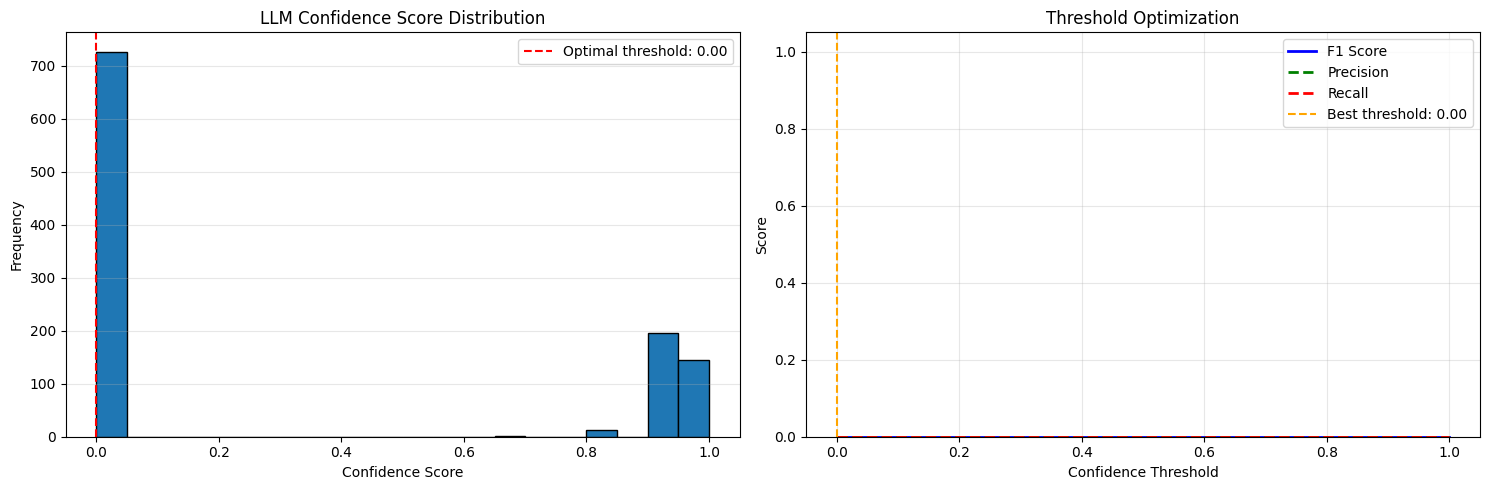


Visualization saved to 'llm_confidence_distribution.png'


In [35]:
import matplotlib.pyplot as plt

if OPENAI_API_KEY:
    try:
        # Load LLM details
        details_df = pd.read_csv('llm_details_original.csv')
        
        # Plot confidence distribution
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Left: Histogram of confidence scores
        ax1.hist(details_df['confidence'], bins=20, edgecolor='black')
        ax1.axvline(x=0.0, color='red', linestyle='--', label='Optimal threshold: 0.00')
        ax1.set_xlabel('Confidence Score')
        ax1.set_ylabel('Frequency')
        ax1.set_title('LLM Confidence Score Distribution')
        ax1.legend()
        ax1.grid(axis='y', alpha=0.3)
        
        # Right: Threshold vs metrics
        llm_results = results_df[results_df['Method'] == 'LLM-GPT4o-mini']
        if len(llm_results) > 0:
            original_result = llm_results[llm_results['Dataset'] == 'Original'].iloc[0]
            
            # Calculate metrics for different thresholds
            thresholds = np.arange(0.0, 1.01, 0.05)
            f1_scores = []
            precisions = []
            recalls = []
            
            for threshold in thresholds:
                predicted = set()
                for _, row in details_df.iterrows():
                    if row['matched_id_b'] is not None and row['confidence'] >= threshold:
                        predicted.add((row['id_a'], row['matched_id_b']))
                
                tp = len(predicted & true_matches)
                fp = len(predicted - true_matches)
                fn = len(true_matches - predicted)
                
                precision = tp / len(predicted) if len(predicted) > 0 else 0.0
                recall = tp / len(true_matches) if len(true_matches) > 0 else 0.0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
                
                f1_scores.append(f1)
                precisions.append(precision)
                recalls.append(recall)
            
            ax2.plot(thresholds, f1_scores, 'b-', linewidth=2, label='F1 Score')
            ax2.plot(thresholds, precisions, 'g--', linewidth=2, label='Precision')
            ax2.plot(thresholds, recalls, 'r--', linewidth=2, label='Recall')
            ax2.axvline(x=original_result['Threshold'], color='orange', linestyle='--', 
                       label=f'Best threshold: {original_result["Threshold"]:.2f}')
            ax2.set_xlabel('Confidence Threshold')
            ax2.set_ylabel('Score')
            ax2.set_title('Threshold Optimization')
            ax2.legend()
            ax2.grid(alpha=0.3)
            ax2.set_ylim([0, 1.05])
        
        plt.tight_layout()
        plt.savefig('llm_confidence_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\nVisualization saved to 'llm_confidence_distribution.png'")
        
    except FileNotFoundError:
        print("LLM details file not found. Run the experiments first.")
    except Exception as e:
        print(f"Could not create visualization: {e}")
else:
    print("Skipped (no API key)")